# Load and Inspect the "Dirty" Data

   Customer_ID  Age    City      Income Membership_Tier  Credit_Score  Churned
0            1   56   Paris  5000000.00        Platinum         564.0        0
1            2   69  London    45727.67          Bronze         439.0        1
2            3   46   Paris    42520.99          Silver         780.0        1
3            4   32  Mumbai    27475.65          Silver         536.0        0
4            5   60  Mumbai    94335.31          Silver         371.0        1
--- Missing Values Count ---
Customer_ID          0
Age                  0
City                50
Income             100
Membership_Tier      0
Credit_Score       150
Churned              0
dtype: int64

--- Visualizing the Outlier ---


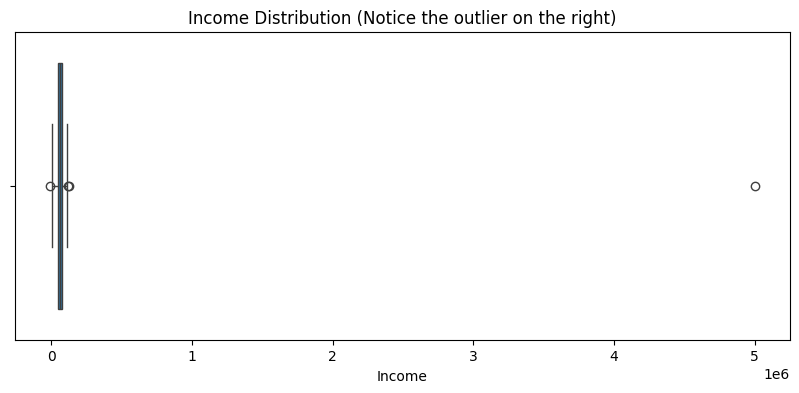

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('customer_churn_data.csv')
print(df.head())

print("--- Missing Values Count ---")
print(df.isnull().sum())

print("\n--- Visualizing the Outlier ---")
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['Income'])
plt.title("Income Distribution (Notice the outlier on the right)")
plt.show()

# Step 1: Handling Missing Values (Imputation)

 We have missing values in Income, Credit_Score, and City.

## Income:
Since we have a massive outlier (5M), using the Mean is dangerous
because it will be skewed high. We should use the Median.

## Credit_Score:
Credit Score is usually normally distributed, so using the Mean is safe.

## City:
This is a categorical variable.
We can impute using the Mode (most frequent city) or a constant like "Unknown".


In [8]:
from sklearn.impute import SimpleImputer

# 1. Numerical Imputation
# Income: Use Median (Robust to outliers)
imputer_median = SimpleImputer(strategy='median')
df['Income'] = imputer_median.fit_transform(df[['Income']])

# Credit_Score: Use Mean
imputer_mean = SimpleImputer(strategy='mean')
df['Credit_Score'] = imputer_mean.fit_transform(df[['Credit_Score']])

# 2. Categorical Imputation
# City: Use Most Frequent (Mode)
imputer_mode = SimpleImputer(strategy='most_frequent')
# We must reshape because fit_transform expects 2D array for single column
df['City'] = imputer_mode.fit_transform(df[['City']]).ravel() 

print("Missing values after imputation:\n", df.isnull().sum())

Missing values after imputation:
 Customer_ID        0
Age                0
City               0
Income             0
Membership_Tier    0
Credit_Score       0
Churned            0
dtype: int64


# Step 2: Handling Outliers (Log Transformation)
The Income column has a value of 5,000,000 while the average is 60,000. This massive range will ruin distance-based algorithms (like KNN) or gradient descent.

Instead of deleting the row, we apply a Log Transformation. This compresses the range of the data, pulling the outlier closer to the pack.

C:\Users\Admin\AppData\Local\Programs\Python\Python314\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


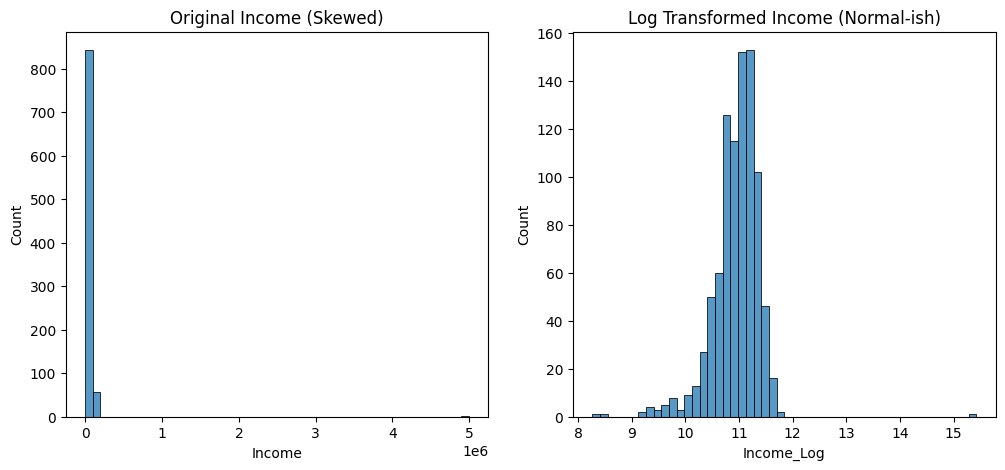

In [16]:
# Apply Log Transformation (log1p calculates log(1+x) to avoid errors with 0)
df['Income_Log'] = np.log1p(df['Income'])

# Visual comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['Income'], ax=ax[0], bins=50)
ax[0].set_title("Original Income (Skewed)")

sns.histplot(df['Income_Log'], ax=ax[1], bins=50)
ax[1].set_title("Log Transformed Income (Normal-ish)")
plt.show()

# Step 3: Encoding Categorical Data
We have two types of categories here:

Nominal (City): No inherent order (Paris isn't "greater" than Tokyo). We use One-Hot Encoding.

Ordinal (Membership_Tier): Has order (Bronze < Silver < Gold < Platinum). We use Ordinal Encoding.

In [14]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# --- A. Ordinal Encoding for Membership ---
# We define the order explicitly so the model knows Platinum > Bronze
tier_order = [['Bronze', 'Silver', 'Gold', 'Platinum']]
ord_enc = OrdinalEncoder(categories=tier_order)

df['Membership_Code'] = ord_enc.fit_transform(df[['Membership_Tier']])

# --- B. One-Hot Encoding for City ---
# drop='first' removes one column (usually 'City_London' alphabetically) to avoid collinearity
# sparse_output=False gives us a readable numpy array
ohe = OneHotEncoder(drop='first', sparse_output=False, dtype=int)
city_encoded = ohe.fit_transform(df[['City']])

# Get the new column names (e.g., City_Mumbai, City_New York...)
city_columns = ohe.get_feature_names_out(['City'])
city_df = pd.DataFrame(city_encoded, columns=city_columns)

# Concatenate back to main DF
df = pd.concat([df, city_df], axis=1)

# --- CORRECTED PRINT STATEMENT ---
# We explicitly select 'City_New York' (or another city that wasn't dropped)
# We use a try/except block just in case 'New York' happened to be the one dropped
try:
    print(df[['City', 'City_New York', 'Membership_Tier', 'Membership_Code']].head())
except KeyError:
    # If New York was the dropped category, let's just print the first available city column
    first_city_col = city_columns[0]
    print(f"('City_New York' might have been dropped as the reference category)")
    print(df[['City', first_city_col, 'Membership_Tier', 'Membership_Code']].head())

     City  City_New York  City_New York Membership_Tier  Membership_Code
0   Paris              0              0        Platinum              3.0
1  London              0              0          Bronze              0.0
2   Paris              0              0          Silver              1.0
3  Mumbai              0              0          Silver              1.0
4  Mumbai              0              0          Silver              1.0


# Step 4: Feature Scaling
Now we have Age (18-75), Credit_Score (300-850), and Income_Log (10-16). We need them on the same scale (usually centered around 0) so the model weights them equally.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

cols_to_scale = ['Age', 'Credit_Score', 'Income_Log', 'Membership_Code']

# Create new columns with _Scaled suffix
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

print("Mean of scaled columns (should be ~0):", np.mean(df[cols_to_scale], axis=0))
print("Std Dev of scaled columns (should be ~1):", np.std(df[cols_to_scale], axis=0))

Mean of scaled columns (should be ~0): Age               -2.042810e-17
Credit_Score       5.851528e-17
Income_Log         1.268544e-15
Membership_Code   -7.993606e-17
dtype: float64
Std Dev of scaled columns (should be ~1): Age                1.0
Credit_Score       1.0
Income_Log         1.0
Membership_Code    1.0
dtype: float64


# Step 5: Feature Interaction (The "Art" part)
Sometimes the ratio of two numbers is more powerful than the numbers alone. Let's create a feature called Credit_Age_Ratio. This could indicate how established a person's credit is relative to their age.

In [18]:
# Re-using original (unscaled) Age and Credit Score for calculation logic
# Note: We must be careful not to divide by zero. 
# Since Age min is 18, we are safe.

df['Credit_Per_Year_Age'] = df['Credit_Score'] / df['Age'] 

# We should scale this new feature too!
df['Credit_Per_Year_Age'] = scaler.fit_transform(df[['Credit_Per_Year_Age']])

# Final: The "Clean" Data ready for ML

In [19]:
# Drop raw/unused columns
cols_to_drop = ['Customer_ID', 'City', 'Membership_Tier', 'Income'] # Income was replaced by Income_Log
final_df = df.drop(cols_to_drop, axis=1)

print("--- Final Feature Set ---")
print(final_df.head())
print("\nFinal Shape:", final_df.shape)

--- Final Feature Set ---
        Age  Credit_Score  Churned  Membership_Code  City_Mumbai  \
0  0.599081     -0.112688        0         1.949286            0   
1  1.397611     -0.917065        1        -1.090141            0   
2 -0.015172      1.277274        1        -0.076999            0   
3 -0.875127     -0.292869        0        -0.076999            1   
4  0.844783     -1.354645        1        -0.076999            1   

   City_New York  City_Paris  City_Tokyo  City_nan  City_Mumbai  \
0              0           1           0         0            0   
1              0           0           0         0            0   
2              0           1           0         0            0   
3              0           0           0         0            1   
4              0           0           0         0            1   

   City_New York  City_Paris  City_Tokyo  City_nan  Income_Log  \
0              0           1           0         0   10.199558   
1              0           0  

In [20]:
final_df

,Age,Credit_Score,Churned,Membership_Code,City_Mumbai,City_New York,City_Paris,City_Tokyo,City_nan,City_Mumbai,City_New York,City_Paris,City_Tokyo,City_nan,Income_Log,Credit_Per_Year_Age
0,0.599081,-0.112688,0,1.949286,0,0,1,0,0,0,0,1,0,0,10.199558,-0.019341
1,1.397611,-0.917065,1,-1.090141,0,0,0,0,0,0,0,0,0,0,-0.482359,-0.069773
2,-0.015172,1.277274,1,-0.076999,0,0,1,0,0,0,0,1,0,0,-0.647792,-9.069779
3,-0.875127,-0.292869,0,-0.076999,1,0,0,0,0,1,0,0,0,0,-1.641436,0.036985
4,0.844783,-1.354645,1,-0.076999,1,0,0,0,0,1,0,0,0,0,1.165370,-0.171849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.568000,NaN,0,0.936144,0,0,0,1,0,0,0,0,1,0,0.533535,NaN
996,-0.322299,-0.428004,0,1.949286,0,0,1,0,0,0,0,1,0,0,0.596189,0.144010
997,-1.489380,0.505073,0,1.949286,0,1,0,0,0,0,1,0,0,0,0.007477,-0.035612
998,0.291955,NaN,0,0.936144,0,0,0,1,0,0,0,0,1,0,NaN,NaN


# Summary of What We Built
#### Imputed missing values (filled the gaps).
#### Transformed the 5M outlier using Logarithms so it doesn't break the model.
#### Encoded City (One-Hot) and Membership (Ordinal).
#### Scaled all numbers to Z-scores.
#### Created a new derived feature (Credit_Per_Year_Age).
This final_df is now mathematically pure and ready to be fed into a Logistic Regression or Neural Network.